In [47]:
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy import stats
from scipy.stats import exponweib
from scipy.optimize import minimize
from scipy.misc import factorial
import scipy.optimize
import time

In [17]:
# Logan Herrera
# Stanford Student Space Initiative
# IREC 2017


# https://www.ncdc.noaa.gov/data-access/weather-balloon/integrated-global-radiosonde-archive
# https://www1.ncdc.noaa.gov/pub/data/igra/data/data-por/
# https://www1.ncdc.noaa.gov/pub/data/igra/data/igra2-data-format.txt

any_header_pattern =    r'#USM0007236[45]\s[0-9]{4}\s[0-9]{2}\s[0-9]{2}'
target_header_pattern = r'#USM0007236[45]\s20[0-1][0-9]\s0[6-7]'    

#inputfile = 'USM00072364-ABQ-data.txt'        # Albuquerque
#outputfile = 'ABQ_IGRA_snippedoutput.txt'

inputfile = 'USM00072365-ST-data.txt'          # Santa Teresa
outputfile ='ST_IGRA_snippedoutput.txt'

any_header = re.compile(any_header_pattern)
target_header = re.compile(target_header_pattern)
f = open(inputfile,'r')
g = open(outputfile,'w')

data_block = False
for line in f:
    if not any_header.match(line) and data_block == True:
        g.write(line)    
    elif target_header.match(line):
        data_block = True
        g.write(line)        
    else:
        data_block = False
  
f.close()
g.close()
print('done!')

done!


In [3]:
max_alt = 18288    # 60,000 ft MSL
min_points = 5

#inputfile = 'simplefile.txt'
#inputfile = 'ST_IGRA_snippedoutput.txt'
inputfile = 'ABQ_IGRA_snippedoutput.txt'

f = open(inputfile,'r')

key = None
data = dict()
for line in f:
    if 'USM00072364' in line or 'USM00072365' in line:
        key = line[13:26]
        key = key.replace(' ','')
        data[key] = None
    else:
        line = line.replace('A',' ')           # delete non-numeric characters (spurious A's)
        line = line.replace('B',' ')           # delete non-numeric characters (spurious B's)
        line = line.split()                    # split data on white space
        latest_datum = np.array(list(map(float, line)))    # convert list of strings to list of floats
        if latest_datum[3] <= max_alt and latest_datum[4] and latest_datum[7] != -9999 and latest_datum[8] != -9999:
            latest_datum[8] = latest_datum[8] / 10
            if data[key] is None:
                data[key] = latest_datum
            else:
                data[key] = np.vstack((data[key], latest_datum))          # append new data below previous data in key-value pair

# column 3 is GPH
# column 7 is WDIR
# column 8 is WSPD

total_rejected = 0
badkeys = []
for b in data.keys():
    if data[b] is None or data[b].ndim == 1 or len(data[b]) <= min_points:
        total_rejected += 1     
        badkeys.append(b)
        
for c in badkeys:        
    del data[c]

print('Number of rejected balloon flights = ' + str(total_rejected))
        
data_interp = dict()
for a in data.keys():
    data_interp[a] = (interp1d(data[a][:,3], data[a][:,7],kind='linear',fill_value='extrapolate'), 
                      interp1d(data[a][:,3], data[a][:,8],kind='linear',fill_value='extrapolate'))
                        
f.close()
print('done!')


Number of rejected balloon flights = 0
done!


In [4]:
year = np.arange(2000,2016+1,1)
day = np.arange(1,61+1,1)
alt = np.arange(1700,18100+100,100)
speed = np.empty([len(year),len(day),2,len(alt)])
heading = np.empty([len(year),len(day),2,len(alt)])
min_valid_speed = 0        # round erroneously low values up to min_valid_speed
max_valid_speed = 100      # round erroneously high values down to max_valid_speed

for i in year:
    for j in day:
        for k in [0,1]:
            inputkey = str(i) + '0' + str(6 + j//31)
            if j % 31 < 10:
                inputkey += '0'
            inputkey +=  str(j % 31)
            if k == 0:
                inputkey += '00'
            else:
                inputkey += '12'
            
            headingerrors = 0
            for h in range(0,len(alt)):
                try:
                    heading[i-2000,j-1,k,h] = data_interp[inputkey][0](1700+h*100) % 360
                except KeyError:
                    headingerrors +=1
                    heading[i-2000,j-1,k,h] = 0
            
            speederrors = 0
            for z in range(0,len(alt)):
                try:
                    speed[i-2000,j-1,k,z] = min(max(data_interp[inputkey][1](1700+z*100), min_valid_speed), max_valid_speed)
                except KeyError:
                    speederrors += 1
                    speed[i-2000,j-1,k,z] = 0
                    
print('Number of heading errors = ' + str(headingerrors))
print('Number of speed errors = ' + str(speederrors))
            

Number of heading errors = 0
Number of speed errors = 0


In [6]:
max_index = int((33000*0.3048 - 1700)//100 + 1)
average_speed = np.mean(speed[:][:][:][0:max_index])
stddev_speed = np.std(speed[:][:][:][0:max_index])
print('Average speed is ' + str(average_speed) + ' m/s')
print('Standard deviation of speed is ' + str(stddev_speed) + ' m/s')
average_angle = np.rad2deg(np.arctan(np.sum(np.sin(np.deg2rad(heading[:][:][:][0:max_index]))) / 
                                     np.sum(np.cos(np.deg2rad(heading[:][:][:][0:max_index])))))
print('Average wind heading is ' + str(average_angle) + '°')
# this calculated result doesn't match the graphical result below

Average speed is 9.7698564032 m/s
Standard deviation of speed is 8.11151481022 m/s
Average wind heading is 84.7218677191°


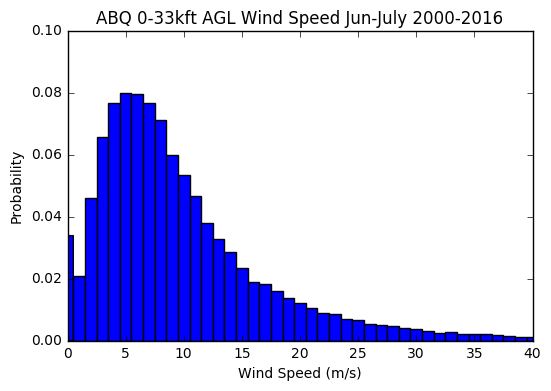

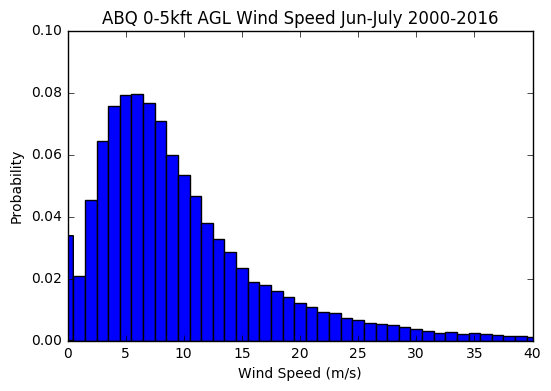

In [20]:
max_index = int((33000*0.3048 - 1700)//100 + 1)
plt.hist(np.ravel(speed[:][:][:][0:max_index]), bins=np.arange(100) - 0.5, normed=True)
plt.title('ABQ 0-33kft AGL Wind Speed Jun-July 2000-2016')
#plt.axvline(mode_all_velocity[0], linewidth=4, color='r')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.xlim(0,40)
plt.ylim(0,0.1)
plt.show()

max_index = int((5000*0.3048 - 1700)//100 + 1)
plt.hist(np.ravel(speed[:][:][:][0:max_index]), bins=np.arange(100) - 0.5, normed=True)
plt.title('ABQ 0-5kft AGL Wind Speed Jun-July 2000-2016')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.xlim(0,40)
plt.ylim(0,0.1)
plt.show()

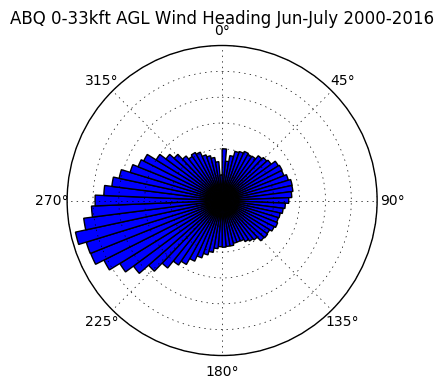

In [8]:
max_index = int((33000*0.3048 - 1700)//100 + 1)
prob, theta, _ = plt.hist(np.ravel(heading[:][:][:][0:max_index]), bins='auto', normed=True)
#plt.title('ABQ 0-33kft AGL Wind Heading Jun-July 2000-2016')
#plt.xlabel('Wind Heading (°)')
#plt.ylabel('Probability')
#plt.xlim(0,360)
#plt.ylim(0,0.02)
#plt.show()

theta = np.deg2rad(theta[:-1])
prob[0] = 0.002
max_height = 0.01

width = (2*np.pi) / len(theta)
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, prob, width=width)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.axes.get_yaxis().set_ticklabels([])
ax.set_title('ABQ 0-33kft AGL Wind Heading Jun-July 2000-2016')

plt.show()

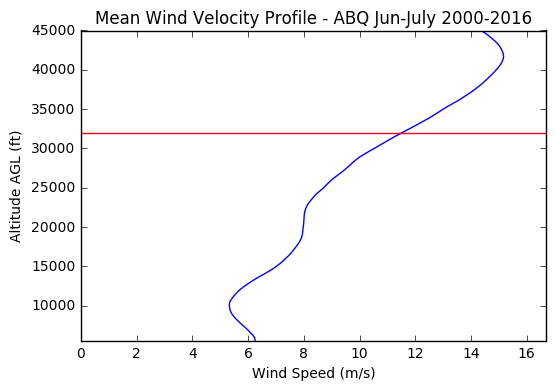

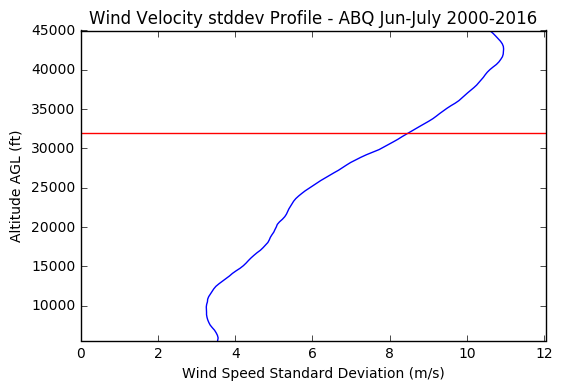

In [15]:
avg_speed_profile = speed.mean(axis=(0,1,2))
avg_speed_stddev_profile = speed.std(axis=(0,1,2))

plt.plot(avg_speed_profile, alt*3.28084, '-')
plt.axhline(32000,color='r')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Mean Wind Velocity Profile - ABQ Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 1.1*max(avg_speed_profile))
plt.show()

plt.plot(avg_speed_stddev_profile, alt*3.28084, '-')
plt.axhline(32000,color='r')
plt.xlabel('Wind Speed Standard Deviation (m/s)')
plt.ylabel('Altitude AGL (ft)')
plt.title('Wind Velocity stddev Profile - ABQ Jun-July 2000-2016')
plt.ylim(min(alt*3.28084),45000)
plt.xlim(0, 1.1*max(avg_speed_stddev_profile))
plt.show()

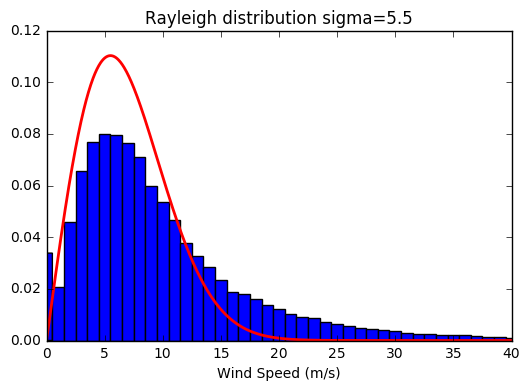

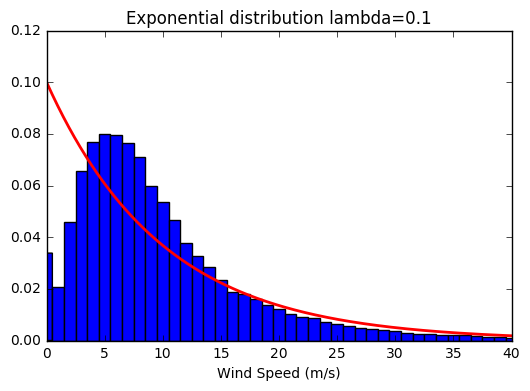

In [14]:
def exponential(x, lamb):
    return lamb*np.exp(-lamb*x)

def rayleigh(x, sigma):
    return x/sigma**2*np.exp(-x**2/(2*sigma**2))

data = np.ravel(speed[:][:][:][0:max_index])

x_plot = np.linspace(0, 40, 1000)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.plot(x_plot, rayleigh(x_plot, 5.5), 'r-', lw=2)
plt.xlim(0, 40)
plt.title('Rayleigh distribution sigma=5.5')
plt.xlabel('Wind Speed (m/s)')
plt.show()

x_plot = np.linspace(0, 40, 1000)
plt.hist(data, bins=np.arange(100) - 0.5, normed=True)
plt.plot(x_plot, exponential(x_plot, 0.1), 'r-', lw=2)
plt.xlim(0, 40)
plt.title('Exponential distribution lambda=0.1')
plt.xlabel('Wind Speed (m/s)')
plt.show()


36.8751 seconds to compute
Most likely wind speed is 5.262 m/s
Two sigma wind speed interval is (0.88679784508341863, 26.569635625894222) m/s


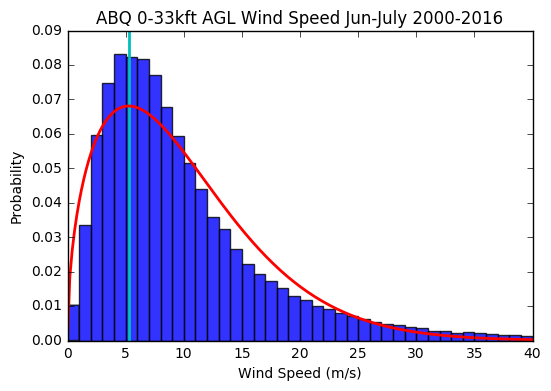

In [54]:
max_v = 40
max_index = int((33000*0.3048 - 1700)//100 + 1)
#max_index = 2
data = np.ravel(speed[:][:][:][0:max_index])
data = np.array(list(filter(lambda x: x<max_v and x>0, list(data))))

t0 = time.time()
p = stats.weibull_min.fit(data, floc=0)
greatest_prob = scipy.optimize.fmin(lambda x: -scipy.stats.weibull_min.pdf(x, *p), 5, disp=False)
two_sigma_interval = stats.weibull_min.interval(0.9544, p[0], loc=0, scale=p[2])
t1 = time.time()
print(str(round(t1-t0,4)) + ' seconds to compute')

X = np.linspace(0, max_v, 200)
plt.hist(data,bins=int(max_v),alpha=0.8,normed=True,color='b')
plt.axvline(greatest_prob,color='c',lw=2)
plt.plot(X, scipy.stats.weibull_min.pdf(X, *p),color='r',lw=2)
plt.xlim(0,max_v)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.title('ABQ 0-33kft AGL Wind Speed Jun-July 2000-2016')

print('Most likely wind speed is ' + str(round(greatest_prob[0],3)) + ' m/s')
print('Two sigma wind speed interval is ' + str(two_sigma_interval) + ' m/s')
plt.show()


0.007 seconds to compute
Most likely wind speed is 5.265 m/s
Two sigma wind speed interval is (1.2709795221907751, 27.126898874126738) m/s


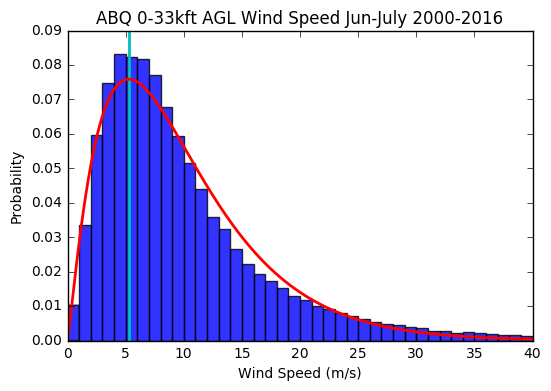

In [56]:
max_v = 40
max_index = int((33000*0.3048 - 1700)//100 + 1)
#max_index = 2
data = np.ravel(speed[:][:][:][0:max_index])
data = np.array(list(filter(lambda x: x<max_v and x>0, list(data))))

t0 = time.time()
p = stats.gamma.fit(data, floc=0)
greatest_prob = scipy.optimize.fmin(lambda x: -scipy.stats.gamma.pdf(x, *p), 5, disp=False)
two_sigma_interval = stats.gamma.interval(0.9544, p[0], loc=0, scale=p[2])
t1 = time.time()
print(str(round(t1-t0,4)) + ' seconds to compute')

X = np.linspace(0, max_v, 200)
plt.hist(data,bins=int(max_v),alpha=0.8,normed=True,color='b')
plt.axvline(greatest_prob,color='c',lw=2)
plt.plot(X, scipy.stats.gamma.pdf(X, *p),color='r',lw=2)
plt.xlim(0,max_v)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Probability')
plt.title('ABQ 0-33kft AGL Wind Speed Jun-July 2000-2016')

print('Most likely wind speed is ' + str(round(greatest_prob[0],3)) + ' m/s')
print('Two sigma wind speed interval is ' + str(two_sigma_interval) + ' m/s')
plt.show()
